In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from dataflow import df_train, df_test, df_geography, df_product

In [ ]:
# Kết nối tự nhiên giữa các bảng
df_train = df_train.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')
df_test = df_test.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')

In [3]:
import torch

print(torch.cuda.is_available())      # True nếu có GPU
print(torch.cuda.device_count())      # Số lượng GPU có thể sử dụng
print(torch.cuda.get_device_name(0))  # Tên của GPU

True
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [4]:
# Kiểm tra và thiết lập device (GPU nếu có)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [5]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Lấy các cột cần thiết cho mô hình
df_model = df_train[['Date', 'Units', 'Revenue']]
df_test = df_test[['Date', 'Units', 'Revenue']]

# Nhóm theo ngày và tính tổng số lượng bán (Units) và doanh thu (Revenue) mỗi ngày
df_train = df_model.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()
df_test = df_test.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()


# 1. Xử lý dữ liệu thiếu

In [6]:
# Tạo dãy ngày đầy đủ từ ngày nhỏ nhất đến ngày lớn nhất trong dữ liệu
full_date_range = pd.date_range(start=df_train['Date'].min(), end=df_train['Date'].max(), freq='D')

# Đặt cột Date làm index để dễ thao tác
df_train.set_index('Date', inplace=True)

# Reindex DataFrame với dãy ngày đầy đủ. Các ngày thiếu sẽ có giá trị NaN
df_train = df_train.reindex(full_date_range)
df_train.index.name = 'Date'

# Sử dụng nội suy tuyến tính dựa trên thời gian để điền các giá trị thiếu
df_train['Units'] = df_train['Units'].interpolate(method='time')
df_train['Revenue'] = df_train['Revenue'].interpolate(method='time')

# Trong trường hợp giá trị tại đầu hoặc cuối chuỗi vẫn là NaN, sử dụng forward/backward fill
df_train['Units'] = df_train['Units'].ffill().bfill()
df_train['Revenue'] = df_train['Revenue'].ffill().bfill()

# Reset index để đưa Date trở lại làm cột thông thường
df_train = df_train.reset_index()

In [7]:
def add_time_features(df):
    df['day_of_week'] = df['Date'].dt.dayofweek  # 0: Thứ Hai, 6: Chủ Nhật
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Xác định ngày nghỉ lễ dựa trên US Federal Holidays
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
    df['is_holiday'] = df['Date'].isin(holidays).astype(int)
    
    # Xác định mùa theo tháng: Winter (12,1,2), Spring (3,4,5), Summer (6,7,8), Fall (9,10,11)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'fall'
    df['season'] = df['Date'].dt.month.apply(get_season)
    
    # One-hot encode cho thứ trong tuần và mùa
    df = pd.get_dummies(df, columns=['day_of_week', 'season'], drop_first=False)
    return df

In [8]:
df_train = add_time_features(df_train)
df_test = add_time_features(df_test)

In [9]:
scaler = StandardScaler()
# Lưu ý: Chỉ fit trên tập train (df_train) và áp dụng transform cho cả train và test
df_train[['Units', 'Revenue']] = scaler.fit_transform(df_train[['Units', 'Revenue']])
df_test[['Units', 'Revenue']] = scaler.transform(df_test[['Units', 'Revenue']])

In [10]:
# --- Bước 2: Xây dựng Dataset với sliding window ---
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size=30):
        """
        Với mỗi mẫu:
         - x_seq: chuỗi lịch sử (window_size ngày) gồm 2 đặc trưng: Units và Revenue.
         - x_cal: các đặc trưng lịch của ngày cần dự báo (ngoại lai), gồm các cột ngoài Date, Units, Revenue.
         - y: giá trị cần dự báo của ngày đó (Units và Revenue).
        """
        self.window_size = window_size
        self.df = df.sort_values('Date').reset_index(drop=True)
        # Lấy các đặc trưng lịch (ngoại lai) từ cột Date
        self.calendar_feature_cols = [col for col in self.df.columns if col not in ['Date', 'Units', 'Revenue']]
        self.seq_cols = ['Units', 'Revenue']
        
    def __len__(self):
        return len(self.df) - self.window_size
    
    def __getitem__(self, idx):
        # Lấy chuỗi lịch sử từ idx đến idx+window_size-1
        x_seq = self.df.loc[idx:idx+self.window_size-1, self.seq_cols].values.astype(np.float32)
        # Lấy đặc trưng lịch của ngày cần dự báo (ngày thứ window_size)
        x_cal = self.df.loc[idx+self.window_size, self.calendar_feature_cols].values.astype(np.float32)
        # Giá trị cần dự báo của ngày đó
        y = self.df.loc[idx+self.window_size, ['Units', 'Revenue']].values.astype(np.float32)
        return x_seq, x_cal, y

In [11]:
# Tạo dataset cho train (df_train) và test (df_test)
window_size = 30
full_dataset = TimeSeriesDataset(df_train, window_size=window_size)
test_dataset = TimeSeriesDataset(df_test, window_size=window_size)

# Tách ngẫu nhiên tập validation theo seed cố định (20% validation)
seed = 42
torch.manual_seed(seed)
dataset_length = len(full_dataset)
val_size = int(0.2 * dataset_length)
train_size = dataset_length - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

In [12]:
# DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# --- Bổ sung lớp Attention ---
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # Linear để tính điểm cho mỗi bước thời gian
        self.attn = nn.Linear(hidden_dim, 1)
    
    def forward(self, lstm_output):
        # lstm_output: shape (batch, seq_len, hidden_dim)
        # Tính điểm attention cho mỗi bước thời gian
        attn_scores = self.attn(lstm_output)  # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # normalize theo seq_len
        # Lấy tổng trọng số (weighted sum) của các hidden states
        context = torch.sum(attn_weights * lstm_output, dim=1)  # (batch, hidden_dim)
        return context

In [14]:
# --- Mô hình mới với Attention ---
class LSTMWithAttentionAndCalendar(nn.Module):
    def __init__(self, seq_input_dim, cal_input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        """
        Mô hình sử dụng Conv1d, LSTM, Attention, và kết hợp với các đặc trưng lịch.
        """
        super(LSTMWithAttentionAndCalendar, self).__init__()
        # Conv1d trích xuất đặc trưng cục bộ từ chuỗi lịch sử
        self.conv1 = nn.Conv1d(in_channels=seq_input_dim, out_channels=16, kernel_size=3, padding=1)
        self.bn_conv = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        
        # LSTM: đầu vào từ Conv1d có kích thước 16
        self.lstm = nn.LSTM(16, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        # Lớp Attention để tính trọng số trên toàn bộ chuỗi LSTM
        self.attention = Attention(hidden_dim)
        
        # Kết hợp đầu ra attention với đặc trưng lịch (calendar features)
        self.fc1 = nn.Linear(hidden_dim + cal_input_dim, hidden_dim // 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
    
    def forward(self, x_seq, x_cal):
        # x_seq: (batch, seq_len, seq_input_dim)
        # Chuyển sang (batch, channels, seq_len) cho Conv1d
        x = x_seq.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn_conv(x)
        x = self.relu(x)
        # Chuyển về lại (batch, seq_len, features) cho LSTM
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_dim)
        # Áp dụng Attention để lấy context vector (batch, hidden_dim)
        context = self.attention(lstm_out)
        # Kết hợp context với đặc trưng lịch của ngày dự báo
        combined = torch.cat([context, x_cal], dim=1)
        x = self.fc1(combined)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.fc2(x)
        return out

In [15]:
# Xác định kích thước input:
seq_input_dim = 2  # Chỉ có 'Units' và 'Revenue'
cal_feature_cols = [col for col in df_train.columns if col not in ['Date', 'Units', 'Revenue']]
cal_input_dim = len(cal_feature_cols)  # Số lượng đặc trưng lịch (ví dụ: is_weekend, is_holiday, day_of_week_0,..., season_fall, season_spring,...)
hidden_dim = 64
num_layers = 2
output_dim = 2  # Dự báo: Units và Revenue

In [16]:
model = LSTMWithAttentionAndCalendar(seq_input_dim, cal_input_dim, hidden_dim, num_layers, output_dim, dropout=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

num_epochs = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_seq, x_cal, y in train_loader:
        x_seq = x_seq.to(device)
        x_cal = x_cal.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_seq, x_cal)
        loss = criterion(outputs, y)
        loss.backward()
        
        # Áp dụng gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * x_seq.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Tính loss trên tập validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_seq, x_cal, y in val_loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            y = y.to(device)
            
            outputs = model(x_seq, x_cal)
            loss = criterion(outputs, y)
            running_val_loss += loss.item() * x_seq.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
	
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # Checkpoint: lưu mô hình nếu có sự cải thiện trên tập validation
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
        }
        torch.save(checkpoint, 'models/LSTM.pth')
        print(f"Best model updated at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

Best model updated at epoch 1 with validation loss 1.0042
Best model updated at epoch 2 with validation loss 0.8925
Best model updated at epoch 4 with validation loss 0.6899
Best model updated at epoch 5 with validation loss 0.6620
Best model updated at epoch 7 with validation loss 0.6126
Best model updated at epoch 9 with validation loss 0.5997
Epoch [10/100], Train Loss: 0.5892, Val Loss: 0.9494
Best model updated at epoch 13 with validation loss 0.5760
Best model updated at epoch 18 with validation loss 0.5731
Epoch [20/100], Train Loss: 0.4774, Val Loss: 0.5376
Best model updated at epoch 20 with validation loss 0.5376
Best model updated at epoch 21 with validation loss 0.5303
Best model updated at epoch 22 with validation loss 0.5175
Best model updated at epoch 23 with validation loss 0.5121
Best model updated at epoch 25 with validation loss 0.4913
Epoch [30/100], Train Loss: 0.3878, Val Loss: 0.4851
Best model updated at epoch 30 with validation loss 0.4851
Best model updated at

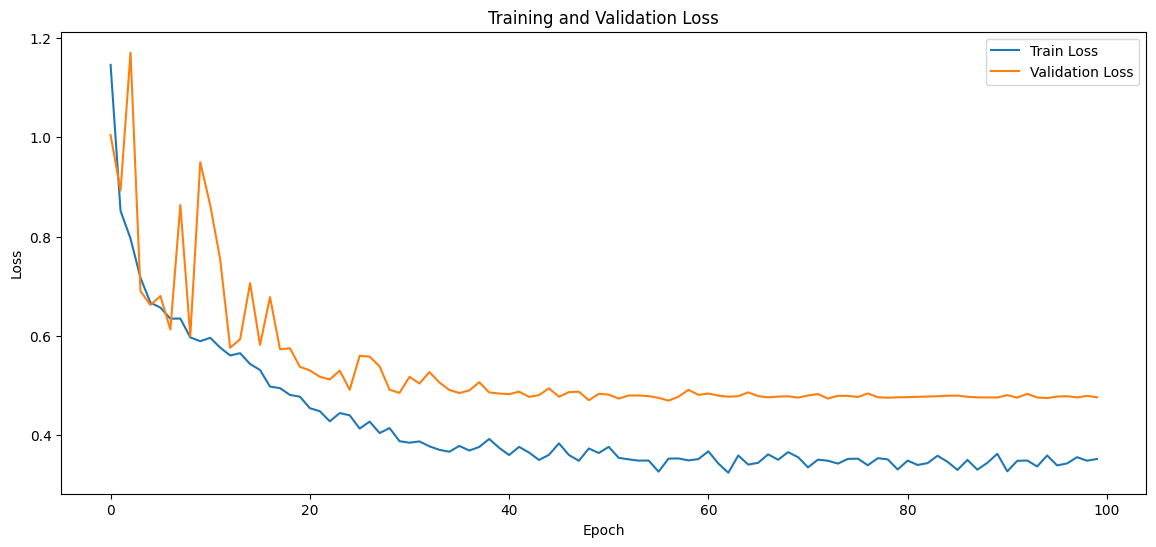

In [19]:
# Vẽ đồ thị loss
plt.figure(figsize=(14, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [24]:
# Load lại mô hình tốt nhất
checkpoint = torch.load('models/LSTM.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Best model loaded with validation loss: {checkpoint['val_loss']:.4f}")

Best model loaded with validation loss: 0.4695


In [21]:
def get_predictions(loader, model, device):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x_seq, x_cal, y in loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            outputs = model(x_seq, x_cal)
            preds.append(outputs.cpu().numpy())
            actuals.append(y.numpy())
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return preds, actuals

In [22]:
# Dự báo trên tập train và test
train_preds, train_actuals = get_predictions(train_loader, model, device)
test_preds, test_actuals = get_predictions(test_loader, model, device)

# Inverse transform để đưa về thang đo ban đầu
train_preds_inv = scaler.inverse_transform(train_preds)
train_actuals_inv = scaler.inverse_transform(train_actuals)
test_preds_inv = scaler.inverse_transform(test_preds)
test_actuals_inv = scaler.inverse_transform(test_actuals)

# Tính các chỉ số đánh giá trên tập test
r2 = r2_score(test_actuals_inv, test_preds_inv)
mape = mean_absolute_percentage_error(test_actuals_inv, test_preds_inv)
rmse = np.sqrt(mean_squared_error(test_actuals_inv, test_preds_inv))
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R-squared: 0.4954
Test MAPE: 0.9193
Test RMSE: 524899.8125


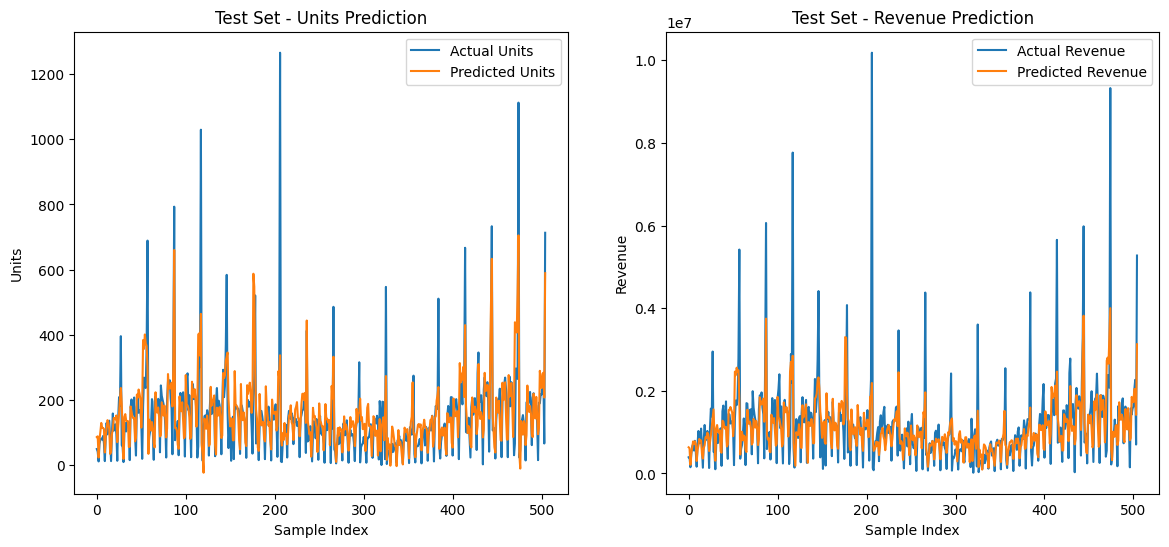

In [23]:
# Vẽ đồ thị dự báo cho Units và Revenue trên tập test
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(test_actuals_inv[:, 0], label='Actual Units')
plt.plot(test_preds_inv[:, 0], label='Predicted Units')
plt.xlabel("Sample Index")
plt.ylabel("Units")
plt.title("Test Set - Units Prediction")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_actuals_inv[:, 1], label='Actual Revenue')
plt.plot(test_preds_inv[:, 1], label='Predicted Revenue')
plt.xlabel("Sample Index")
plt.ylabel("Revenue")
plt.title("Test Set - Revenue Prediction")
plt.legend()
plt.show()